### Crop land use within the UK - Deep dive into Herefordshire crop coverage

#### Reviewing annual changes to land coverage of crops can serve as a proxy for several important indicators of soil and plant health. If we know the neccessary conditions that crop species need in order to grow, we can extrapolate what the environmental conditions are in the regions where these crops dominate, and how these conditions may change as crop coverage changes too. For example, we know legumious crops, such as beans, peanuts and soy, are efficient nitrogen fixers, and flourish on nitrogen- deficient soils. 

Looking at one region in the UK, we have five files to use: 
1. Shapefile containing outline of the catchment area for the UK county Herefordshire
2. Shapefile containing outline of the river that runs through catchment area
3. List of land use codes with respective use and cover descriptions (crop name and plant category)
4. 2020 Crop Map of England (CROME) polygon vector dataset containing the crop types in Herefordshire. It classifies England into over 15 main crop types, grassland, and non-agricultural land covers, such as Woodland, Water Bodies, Fallow Land and other non-agricultural land covers. The classification was created automatically using supervised classification (Random Forest Classification) from a combination Optical Satellite images during the given time period. The dataset was created to aid the classification of crop types from optical imagery, which can be affected by cloud cover. The results were checked against survey data collected by field inspectors and visually validated.
5. As a bove, but for 2021

We will merge all these datasets together, filter for regions with an 80%  confidence interval of the named crop being grown, and visualise this data.

In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 
from shapely.geometry import Point,Polygon
import descartes

In [18]:
# Read in the shapefiles of the river and the catchment area
water_body = gpd.read_file('/Users/sarasabzikari/Documents/Data Study/Geospatial projects/wye-hampton_bishop-conf_kerne_br/WB_GB109055037112_shapefile/WFD_River_Water_Bodies_Cycle_3.shp')
catchment = gpd.read_file('/Users/sarasabzikari/Documents/Data Study/Geospatial projects/wye-hampton_bishop-conf_kerne_br/WB_GB109055037112_shapefile/WFD_River_Water_Body_Catchments_Cycle_3.shp')
code_lookup = pd.read_csv('/Users/sarasabzikari/Documents/Data Study/Geospatial projects/wye-hampton_bishop-conf_kerne_br/CROME_LUCODE_LOOKUP.csv')

In [19]:
# Merge our geodataframe with dataframe containing corresponding land use and cover description per land-use code
def merge_geodata(x):
    gdf = gpd.read_file(x)
    gdf = gdf[gdf['prob']>0.8]
    merged = pd.merge(code_lookup, gdf, left_on='LUCODE', right_on='lucode')
    merged = gpd.GeoDataFrame(merged)
    return merged

In [20]:
geo_2020 = merge_geodata('/Users/sarasabzikari/Documents/Data Study/Geospatial projects/wye-hampton_bishop-conf_kerne_br/RPA_CropMapOfEngland2020HER_GeoJSON/data/Crop_Map_of_England_2020_Herefordshire.json')
geo_2021 = merge_geodata('/Users/sarasabzikari/Downloads/wye-hampton_bishop-conf_kerne_br/RPA_CropMapOfEngland2021HER_GeoJSON/data/Crop_Map_of_England_2021_Herefordshire.json')

In [21]:
geo_2020.head(5)

,Land Cover Description,LUCODE,Land Use Description,OBJECTID,prob,county,cromeid,lucode,shape_Length,shape_Area,geometry
0,Cereal Crops,AC01,Spring Barley,46,0.916,HER,RPA358186224600,AC01,239.998558,4156.872,"POLYGON ((358166.313 224635.359, 358146.313 22..."
1,Cereal Crops,AC01,Spring Barley,304,0.826,HER,RPA354526227753,AC01,239.998558,4156.872,"POLYGON ((354506.313 227787.703, 354486.313 22..."
2,Cereal Crops,AC01,Spring Barley,371,0.848,HER,RPA357166226575,AC01,239.998558,4156.872,"POLYGON ((357126.313 226575.266, 357146.313 22..."
3,Cereal Crops,AC01,Spring Barley,706,0.852,HER,RPA357286223111,AC01,239.998905,4156.884,"POLYGON ((357266.313 223145.797, 357246.313 22..."
4,Cereal Crops,AC01,Spring Barley,1568,0.858,HER,RPA357226222452,AC01,239.998558,4156.872,"POLYGON ((357206.313 222487.625, 357186.313 22..."


In [22]:
# creating visualisation function that will plot spatial data 
def viz(x, col, year):
    fig, ax = plt.subplots(figsize = (6.5,6.5))
    catchment.plot(ax=ax, color='gray')
    water_body.plot(ax=ax, color='white')
    x[x[col]!= 'Water'].plot(ax=ax, column=col, cmap='viridis',
                   edgecolor='none', legend=True)
    plt.title('{} in Herefordshire, {}'.format(col, year))
    plt.tight_layout()

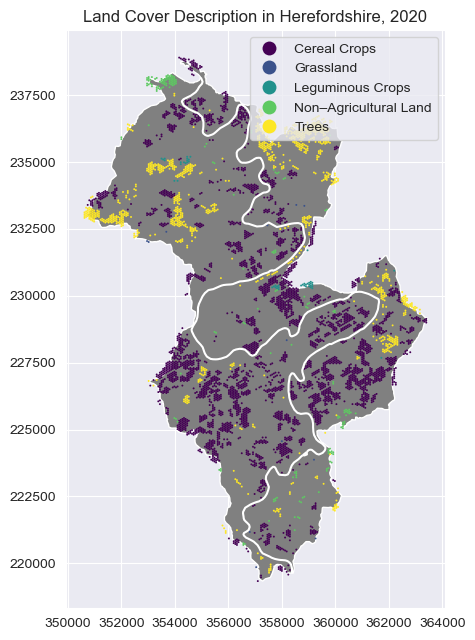

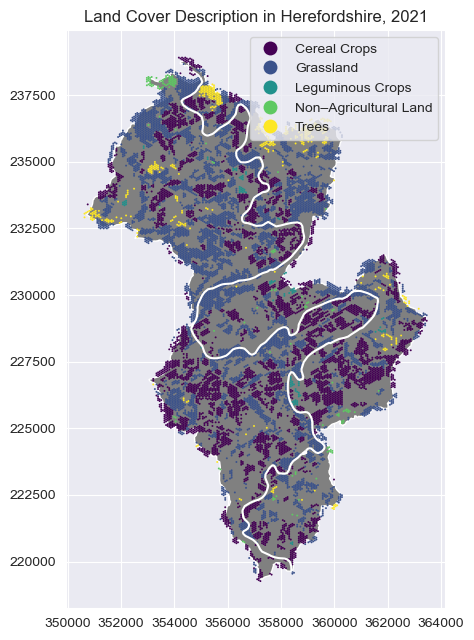

In [23]:
viz(geo_2020, 'Land Cover Description','2020')
viz(geo_2021, 'Land Cover Description','2021')

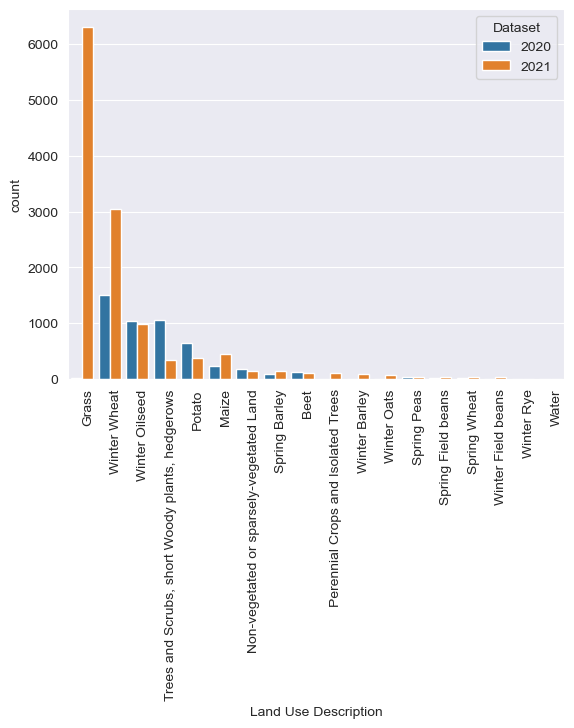

In [24]:
# Bar plot comparing the counts of crop species per year
sns.set_style("darkgrid")
geo_2020['Dataset'] = '2020'
geo_2021['Dataset'] = '2021'
ds = pd.concat([geo_2020, geo_2021])
sns.countplot(x='Land Use Description', data=ds,hue='Dataset', order = ds['Land Use Description'].value_counts().index)
plt.xticks(rotation=90, ha='left')
plt.show()

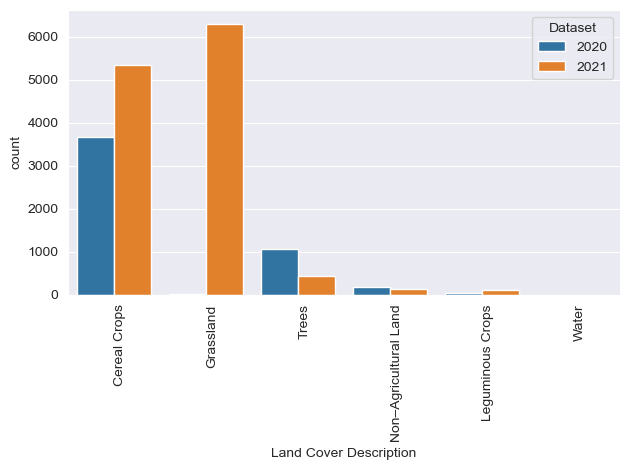

In [25]:
# Visualising counts of each crop type across both years

sns.countplot(x='Land Cover Description', data=ds,hue='Dataset', order = ds['Land Cover Description'].value_counts().index)
plt.xticks(rotation=90, ha='left')

plt.tight_layout()

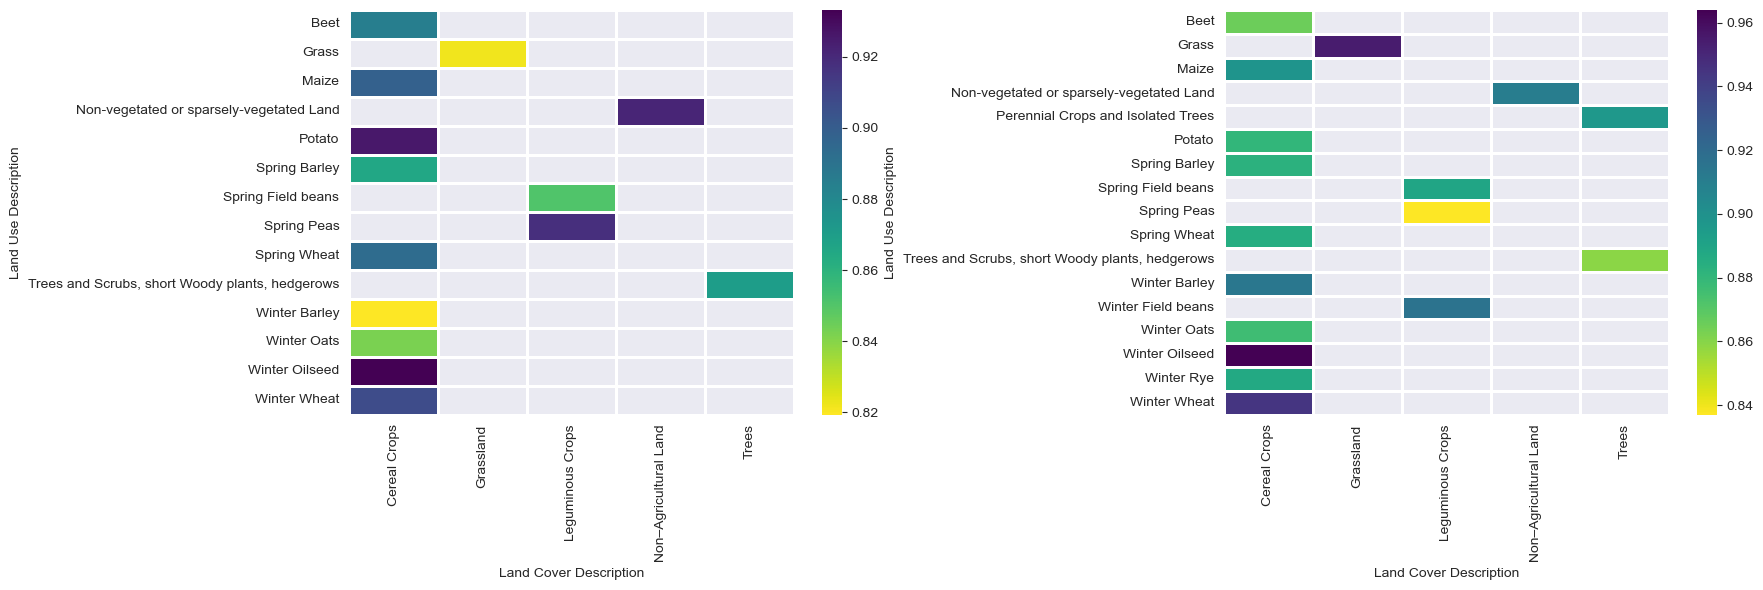

In [26]:
# creating heatmap off of pivot table to see relative probability levels for land use codes - not the ideal use of heatmap but it does the job

pivot_20 = geo_2020.pivot_table(index='Land Use Description', columns='Land Cover Description', values='prob')
pivot_21 = geo_2021[geo_2021['Land Cover Description']!= 'Water'].pivot_table(index='Land Use Description', columns='Land Cover Description', values='prob', aggfunc='mean')

fig,axes = plt.subplots(1,2, figsize=(18,6))

sns.heatmap(pivot_20, cmap='viridis_r',linecolor='white',lw=2, ax=axes[0])
sns.heatmap(pivot_21, cmap='viridis_r',linecolor='white',lw=2,ax=axes[1])


plt.tight_layout()

In [27]:
# Summary of percentage coverage of plant species and crop type
def percent_of_total(df, col):
    value_counts = df[col].value_counts()
    percentage_total = (value_counts/(df.shape[0]))*100
    results = pd.DataFrame(percentage_total)
    return results
    

df = pd.merge(percent_of_total(geo_2020, 'Land Cover Description'), 
                         percent_of_total(geo_2021, 'Land Cover Description'),
                         left_index=True, right_index=True,
                         how = 'outer')

df.rename(columns={'Land Cover Description_x':'2020 Crop Types % of Total',
                                    'Land Cover Description_y':'2021 Crop Types % of Total'},inplace=True)

percent_total = df.style.highlight_max(color = 'lightgreen')
percent_total.highlight_min(color = 'yellow')

,2020 Crop Types % of Total,2021 Crop Types % of Total
Cereal Crops,73.870968,43.289516
Grassland,0.241935,51.200909
Leguminous Crops,0.947581,0.843882
Non–Agricultural Land,3.608871,1.087309
Trees,21.330645,3.554041
Water,nan,0.024343


In [28]:
df = pd.merge(percent_of_total(geo_2020, 'Land Use Description'), 
                         percent_of_total(geo_2021, 'Land Use Description'),
                         left_index=True, right_index=True,
                         how = 'outer')

df.rename(columns={'Land Use Description_x':'2020 Crop Species % of Total',
                                    'Land USe Description_y':'2021 Crop Species % of Total'},inplace=True)

percent_total = df.style.highlight_max(color = 'lightgreen')
percent_total.highlight_min(color = 'yellow')

,2020 Crop Species % of Total,Land Use Description_y
Beet,2.500000,0.860110
Grass,0.241935,51.200909
Maize,4.536290,3.683869
Non-vegetated or sparsely-vegetated Land,3.608871,1.087309
Perennial Crops and Isolated Trees,nan,0.819539
Potato,13.064516,3.010386
Spring Barley,1.895161,1.209023
Spring Field beans,0.342742,0.348913
Spring Peas,0.604839,0.283999
Spring Wheat,0.262097,0.332684


In [29]:
# count the number of regions in both datasets from 2020 and 2021
identical_ids = set(geo_2020['cromeid']).intersection(set(geo_2021['cromeid']))
count = len(identical_ids)
count

2788

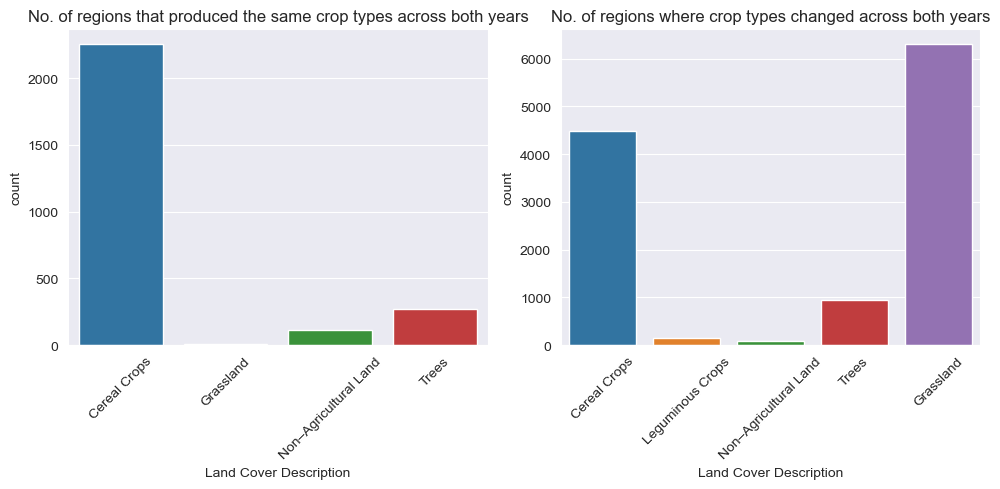

In [30]:
# Visualising the number of regions have produced the same crop type across both years

same_lucode = pd.merge(geo_2020, geo_2021, on=['cromeid', 'Land Cover Description'], how='inner')
same_lucode = gpd.GeoDataFrame(same_lucode)
same_lucode = same_lucode.set_geometry('geometry_y')

combined = pd.concat([geo_2020, geo_2021])
diff = combined.drop_duplicates(subset=["cromeid", "Land Cover Description"], keep=False)

fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.countplot(ax=axes[0],x='Land Cover Description', data=same_lucode,)
sns.countplot(ax=axes[1],x='Land Cover Description', data=diff[diff['Land Cover Description']!='Water'])

for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)   

titles = ['No. of regions that produced the same crop types across both years','No. of regions where crop types changed across both years']
for axes, title in zip(axes.flat, titles):
    axes.set_title(title)

plt.tight_layout()


In [31]:
print('{} of total recorded regions in both 2020 and 2021 had the same crop coverage across both years, while {} had different crop coverage across both years'
      .format(same_lucode['cromeid'].count(),diff['cromeid'].count()))

2652 of total recorded regions in both 2020 and 2021 had the same crop coverage across both years, while 11980 had different crop coverage across both years


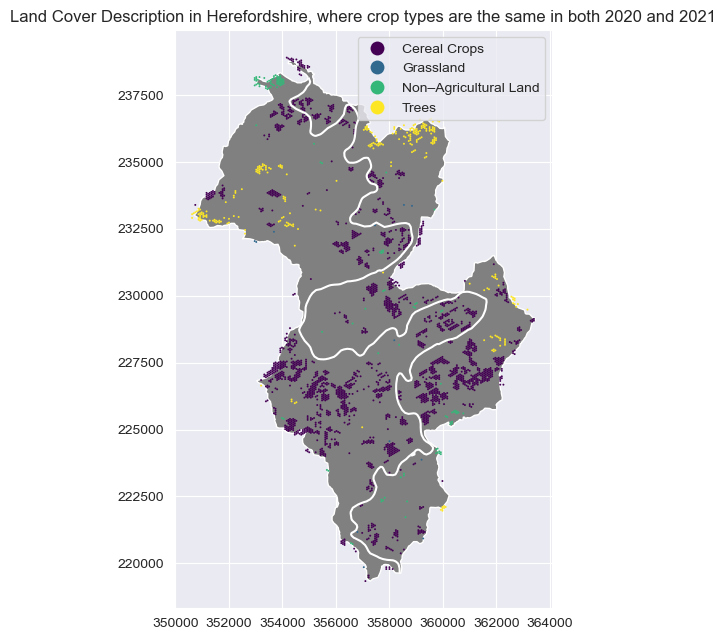

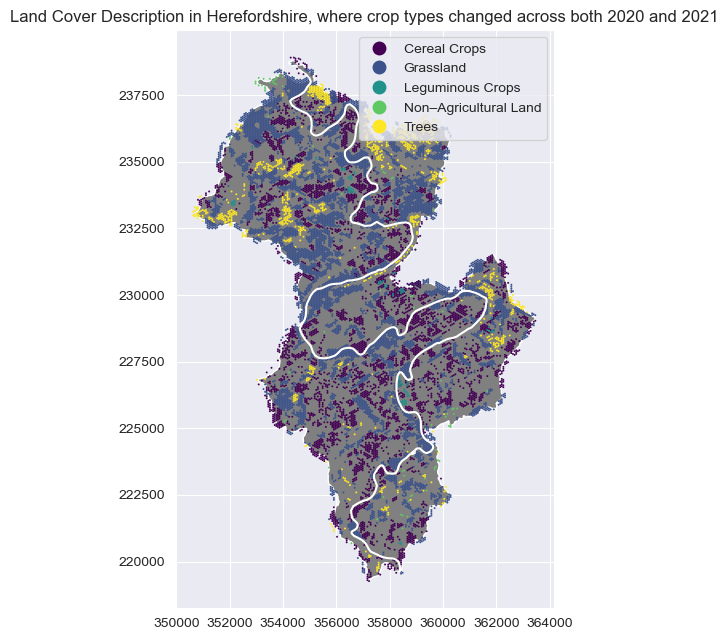

In [32]:
# and spatial visualisation...
viz(same_lucode, 'Land Cover Description', 'where crop types are the same in both 2020 and 2021')
viz(diff, 'Land Cover Description','where crop types changed across both 2020 and 2021')

### Conclusions: 

1) Both years show large differences in crop coverage. We know that 2788 land plots included in the 2020 dataset are also recorded in the 2021 dataset, and 2652 of these had the same crop coverage across both years. That leaves us with 136 land plots that have different crop types grown between the two years (excluding the additional regions recorded in 2021). 

2) Without any additional context it's hard to know the likelihood that 136 of the 2788 regions recorded in both datasets would have changed their crop types. We know that the average confidence of recorded plant coverage (granted the dataset is filtered for >80% probability) increased from one year to another - this could be due to improvements in data collection and validation, but hard to know. All we know is that this could be a good indication that data became more reliable with time, but it doesn't tell us whether we can compare between the years. Perhaps a land owner decided to undergo grassland conversion between 2020 and 2021. However, the fact that a total of 11844 additional land plots were included in the 2021 dataset suggests changes in the data collection system, and classification of land plots, had a large impact on the quality of the data.

3) Since I'm not confident comparing between the years, I will look into estimating the quality of the soil during 2021 in the Herefordshire (HER) county based on the crop type and species grown:
- Grasslands are the most prominent crop type recorded in HER, covering 51% of the recorded land plots. The soils of grasslands tend to be deep with fertile upper layers, nutrient-rich from the growth and decay of deep. Research shows that the rotted roots hold the soil together and provide a food source for living plants. A positive indication of soil quality for HER!
- There is also a high proportion of cereal crops (43%). Monocropping gradually depletes the soil of certain nutrients and selects for a highly competitive pest and weed community. It is likely that additional practices must be put in place to enhance the soil fertility in this regions, such as using manure, crop-rotation etc. 
- Leguminous crops cover ~1% of the recorded land plots. This crop category are largely valued as "soil building" crops. Growing them has been shown to improve soil quality through increasing the soil reserves of organic matter, improving soil structure, enhancing nitrogen-supply in soils via nitrogen fixation, reducing soil erosion via wind and water and many other positive properties. The growing concerns of declining soil quality and rising nitrogen fertilizer costs have led to renewed interest in legumes and the role of legumes as a nitrogen supplier in the rotation of cover crops.

Till next time! 